In [1]:
from helper_code import *
import numpy as np, os, sys, joblib
import ecg_plot
import pandas as pd
from glob import glob
import os
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tsai.all import *
import torch
import optuna
from optuna.integration import FastAIPruningCallback
from sklearn.metrics import classification_report
import transformation_funcs as tfs
import seaborn as sns
from torchsummary import summary
torch.cuda.set_device(2) 

In [2]:
def snomedConvert(label_df,snomed=True):
    codes =  pd.read_csv("data/codes.csv",sep=";")[["Dx","SNOMED CT Code"]]
    if snomed:
        label_df.columns = [codes[codes["SNOMED CT Code"] == int(x)]["Dx"].item() for x in label_df.columns]
        return label_df
DATASET_NAME = "WFDB_CPSC2018"
X = np.load('./data/big_numpy_datasets/%s.npy'%DATASET_NAME, mmap_mode='c')
label_df = pd.read_csv("data/%s.csv"%DATASET_NAME).drop(columns=["headers","leads"])
y = snomedConvert(label_df)


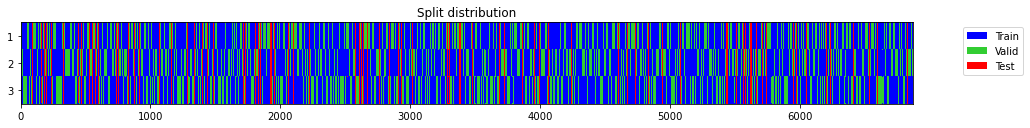

Counts by label: {'right bundle branch block': 1857, 'sinus rhythm': 918, 'atrial fibrillation': 1221, 'ventricular ectopics': 700, 'st depression': 869, 'left bundle branch block': 236, 'st elevation': 220, '1st degree av block': 722, 'premature atrial contraction': 616}


In [13]:

cv_splits = get_splits(y.to_numpy(), n_splits = 3, valid_size=.1,test_size=0.1, stratify=False, random_state=23, shuffle=True)
y_multi = []
for i,row in y.iterrows():
    sample_labels = []
    for i,r in enumerate(row):
        if r == True:
            sample_labels.append(y.columns[i])
        
    y_multi.append(list(tuple(sample_labels)))
label_counts = collections.Counter([a for r in y_multi for a in r])
print('Counts by label:', dict(label_counts))

In [14]:
import imp 
imp.reload(tfs)

<module 'transformation_funcs' from '/home/amirsalimi/ecg_augmentation/transformation_funcs.py'>

epoch,train_loss,valid_loss,accuracy_multi,balanced_accuracy_multi,precision_multi,recall_multi,specificity_multi,F1_multi,time
0,0.820382,0.800042,0.119294,0.500153,0.119057,1.000000,0.000305,0.212771,00:05
1,0.801701,0.792402,0.119401,0.500214,0.119070,1.000000,0.000428,0.212792,00:04
2,0.784452,0.779014,0.119294,0.499950,0.119015,0.999534,0.000366,0.212694,00:04
3,0.768169,0.758834,0.119509,0.500082,0.119041,0.999554,0.000611,0.212736,00:05
4,0.755385,0.745979,0.120370,0.500763,0.119184,1.000000,0.001526,0.212975,00:04
5,0.745568,0.738366,0.123170,0.502158,0.119479,0.999551,0.004766,0.213435,00:04
6,0.736754,0.729066,0.125646,0.503562,0.119775,0.999551,0.007574,0.213908,00:04
7,0.730789,0.727745,0.129145,0.505743,0.120241,1.000000,0.011486,0.214660,00:04
8,0.725342,0.721583,0.136305,0.509029,0.120948,0.998206,0.019853,0.215746,00:04
9,0.719514,0.710002,0.134313,0.508481,0.120827,0.999554,0.017408,0.215585,00:04


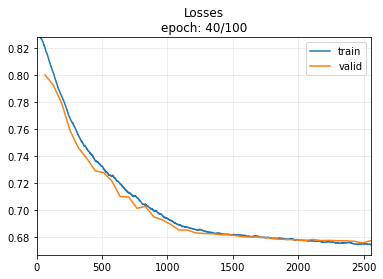

In [ ]:
sf = 0.3
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
                tfs.Scale(scale_factor=sf,),
                tfs.Normalize(),
                tfs.BandPass(int(sf*500),low_cut=60, high_cut=1,leads=12,),
#               tfs.RandomShift(0.1),
#               tfs.MulNoise(6),
#               tfs.CutOutWhenTraining(),
             ]
for cv_num in range(1):
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=cv_splits[cv_num]) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[64, 128], batch_tfms=batch_tfms, num_workers=0)
    metrics =[accuracy_multi, balanced_accuracy_multi, precision_multi, recall_multi, specificity_multi, F1_multi] 
#     model = MiniRocketPlus(dls.vars, dls.c,dls.len)
#     model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
    model = XceptionTimePlus(dls.vars, dls.c)
#     model = MultiTSTPlus(dls.vars, dls.c,500,)
    
#     learn = Learner(dls, model, metrics=metrics,loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt()),cbs=[ShowGraph()],)
    learn = Learner(dls,model, metrics=metrics,cbs=[ShowGraph()],)
    learn.fit_one_cycle(100, lr_max=3e-4)
    learn.recorder.plot_metrics()

In [ ]:
#     model = MiniRocketPlus(dls.vars, dls.c,dls.len)
model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
#     model = XceptionTimePlus(dls.vars, dls.c)
#     model = MultiTSTPlus(dls.vars, dls.c,500,)

learn = Learner(dls, model, metrics=metrics,loss_func = BCEWithLogitsLossFlat(pos_weight=dls.train.cws.sqrt()),cbs=[ShowGraph()],)
#     learn = Learner(dls,model, metrics=metrics,cbs=[ShowGraph()],)

In [23]:
tfms  = [None, TSMultiLabelClassification()]
batch_tfms = [
#              TSStandardize(by_sample=True),
                tfs.Scale(scale_factor=sf,),
                tfs.Normalize(),
                tfs.BandPass(int(sf*500),low_cut=60, high_cut=1,leads=12,),
#                 tfs.RandomShift(0.1),
#                 tfs.MulNoise(6),
#                 tfs.CutOutWhenTraining(),
             ]
reports = []
for cv_num in range(1):
    fold_splits = cv_splits[cv_num]
    dsets = TSDatasets(X.astype(float), y_multi, tfms=tfms, splits=(fold_splits[0],fold_splits[1])) # inplace=True by default
    dls   = TSDataLoaders.from_dsets(dsets.train,dsets.valid, bs=[128, 128], batch_tfms=batch_tfms, num_workers=0)
    model = InceptionTimePlus(dls.vars, dls.c, dls.len, depth=8,)
    learn = Learner(dls, model, metrics=metrics, 
                    cbs=[ShowGraph()],)
    learn.load("inception_augmented_%s"%cv_num)
    valid_probas, valid_targets, valid_preds = learn.get_preds(dl=dls.valid, with_decoded=True)

    y_pred = (valid_preds>0)
    y_test = valid_targets

    report = classification_report(y_test, y_pred,target_names = dls.vocab.o2i.keys(),digits=3,output_dict=True)
    reports.append(report)
for report in reports:
    for k,v in report.items():
        report[k] = report[k]["f1-score"]
df = pd.DataFrame(reports).median()
df

1st degree av block             0.000000
atrial fibrillation             0.680921
left bundle branch block        0.808824
premature atrial contraction    0.000000
right bundle branch block       0.921914
sinus rhythm                    0.610753
st depression                   0.202091
st elevation                    0.000000
ventricular ectopics            0.010101
micro avg                       0.589329
macro avg                       0.359400
weighted avg                    0.485901
samples avg                     0.455911
dtype: float64